In [1]:
!pip install pandas
!pip install matplotlib
!pip install scikit-learn
!pip install seaborn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy import stats

In [3]:
df=pd.read_csv('real_time1.csv')

In [4]:
df.columns

Index(['timestamp', 'block_height', 'tx_count', 'mempool_size_mb',
       'min_fee_rate', 'max_fee_rate', 'avg_fee_rate', 'median_fee_rate',
       'fee_rate_10th', 'fee_rate_90th', 'fee_rate_std', 'block_time',
       'difficulty', 'hash_rate', 'mempool_min_fee', 'total_fee',
       'mempool_usage', 'transaction_count', 'block_weight', 'block_version',
       'block_interval', 'block_median_fee_rate', 'time_since_last_block',
       'mempool_fee_histogram', 'bitcoin_price_usd'],
      dtype='object')

In [5]:
df.shape

(5169, 25)

In [6]:
# Convert 'block_time' to datetime
df['block_time'] = pd.to_datetime(df['block_time'], unit='s')

# Set 'block_time' as index
df.set_index('block_time', inplace=True)

In [7]:
df

,timestamp,block_height,tx_count,mempool_size_mb,min_fee_rate,max_fee_rate,avg_fee_rate,median_fee_rate,fee_rate_10th,fee_rate_90th,...,total_fee,mempool_usage,transaction_count,block_weight,block_version,block_interval,block_median_fee_rate,time_since_last_block,mempool_fee_histogram,bitcoin_price_usd
block_time,,,,,,,,,,,,,,,,,,,,,
2024-09-16 06:44:46,1726469858,861523,59716,51.681340,1.0,403.4234,1.8891,2.0068,1.0166,2.0794,...,82339680.0,292674144,4407,3993295,689364992,NaN,2.1032,NaN,"[59691, 10, 7, 1, 2, 1, 1, 2, 0, 1]",58657
2024-09-16 07:01:15,1726470091,861524,57979,50.830730,1.0,14.2340,1.7086,2.0039,1.0160,2.0714,...,77637217.0,288180656,2292,3993188,838860800,989.0,4.0000,989.0,"[57633, 317, 15, 7, 2, 2, 1, 1, 0, 1]",58657
2024-09-16 07:05:01,1726470324,861525,53178,50.142707,1.0,25.1185,1.6743,2.0000,1.0157,2.0714,...,76177612.0,282014400,5760,3993640,551452672,226.0,2.0794,226.0,"[53136, 24, 8, 5, 1, 0, 1, 2, 0, 1]",58701
2024-09-16 07:34:53,1726472117,861526,58865,51.178547,1.0,300.0000,1.7449,2.0068,1.0160,2.0794,...,78821229.0,290099120,3404,3993080,620822528,1792.0,4.8216,1792.0,"[58864, 0, 0, 0, 0, 0, 0, 0, 0, 1]",58863
2024-09-16 07:35:35,1726472180,861527,53746,50.270880,1.0,70.0000,1.6885,2.0000,1.0157,2.0714,...,76581819.0,283002176,5329,3992931,827326464,42.0,2.0952,42.0,"[53717, 14, 7, 3, 3, 1, 0, 0, 0, 1]",58863
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-21 20:24:35,1729542295,866753,101741,35.009057,1.0,330.4091,4.3425,3.0111,1.0133,10.0000,...,110825744.0,213563024,6660,3993450,715472896,26.0,13.0000,26.0,"[101654, 54, 20, 10, 0, 1, 0, 0, 0, 2]",67627
2024-10-21 20:26:22,1729542411,866754,98809,34.557797,1.0,448.5182,4.1097,3.0000,1.0106,10.0000,...,104873100.0,209775808,6313,3993067,663355392,107.0,12.1163,107.0,"[98757, 38, 10, 1, 1, 0, 1, 0, 0, 1]",67627
2024-10-21 21:05:08,1729544737,866755,114600,37.623044,1.0,800.0000,5.4413,3.2927,1.0157,12.1154,...,147125627.0,231969344,3851,3997936,560898048,2326.0,19.3684,2326.0,"[114505, 82, 11, 1, 0, 0, 0, 0, 0, 1]",67739


In [8]:
print("Original data_history shape:", df.shape)

Original data_history shape: (5169, 24)


In [9]:
def extract_histogram_features(histogram):
    if isinstance(histogram, str):
        histogram = eval(histogram)  # Convert string representation to list
    
    total_txs = sum(histogram)
    if total_txs == 0:
        return {
            'hist_low_fee_ratio': 0,
            'hist_med_fee_ratio': 0,
            'hist_high_fee_ratio': 0,
            'hist_fee_diversity': 0
        }
    
    low_fee_ratio = histogram[0] / total_txs
    med_fee_ratio = sum(histogram[1:5]) / total_txs  # Bins 2-5
    high_fee_ratio = sum(histogram[5:]) / total_txs  # Bins 6-10
    
    # Calculate fee diversity (opposite of concentration)
    non_zero_bins = sum(1 for count in histogram if count > 0)
    fee_diversity = (non_zero_bins - 1) / (len(histogram) - 1)  # Normalized to [0, 1]
    
    return {
        'hist_low_fee_ratio': low_fee_ratio,
        'hist_med_fee_ratio': med_fee_ratio,
        'hist_high_fee_ratio': high_fee_ratio,
        'hist_fee_diversity': fee_diversity
    }

new features mean:

hist_low_fee_ratio: Proportion of transactions in the lowest fee bin (first bin).

hist_med_fee_ratio: Proportion of transactions in the medium fee range (bins 2-5).

hist_high_fee_ratio: Proportion of transactions in the high fee range (bins 6-10).

hist_fee_diversity: A measure of how spread out the transactions are across different fee bins.

0 means all transactions are in one bin

1 means transactions are evenly spread across all bins

These features provide insights into:

The overall distribution of transaction fees

Whether most transactions are paying low, medium, or high fees

How diverse the fee landscape is at any given time

In [10]:

df['histogram_features'] = df['mempool_fee_histogram'].apply(extract_histogram_features)

# Split the dictionary into separate columns
df['hist_low_fee_ratio'] = df['histogram_features'].apply(lambda x: x['hist_low_fee_ratio'])
df['hist_med_fee_ratio'] = df['histogram_features'].apply(lambda x: x['hist_med_fee_ratio'])
df['hist_high_fee_ratio'] = df['histogram_features'].apply(lambda x: x['hist_high_fee_ratio'])
df['hist_fee_diversity'] = df['histogram_features'].apply(lambda x: x['hist_fee_diversity'])

# Display the results
print(df[['timestamp', 'mempool_fee_histogram', 'hist_low_fee_ratio', 'hist_med_fee_ratio', 'hist_high_fee_ratio', 'hist_fee_diversity']].head(10))

                      timestamp                  mempool_fee_histogram  \
block_time                                                               
2024-09-16 06:44:46  1726469858    [59691, 10, 7, 1, 2, 1, 1, 2, 0, 1]   
2024-09-16 07:01:15  1726470091  [57633, 317, 15, 7, 2, 2, 1, 1, 0, 1]   
2024-09-16 07:05:01  1726470324    [53136, 24, 8, 5, 1, 0, 1, 2, 0, 1]   
2024-09-16 07:34:53  1726472117     [58864, 0, 0, 0, 0, 0, 0, 0, 0, 1]   
2024-09-16 07:35:35  1726472180    [53717, 14, 7, 3, 3, 1, 0, 0, 0, 1]   
2024-09-16 07:50:47  1726473064     [56722, 6, 1, 0, 0, 0, 0, 0, 0, 1]   
2024-09-16 07:59:15  1726473568    [56258, 11, 2, 1, 1, 0, 0, 0, 0, 1]   
2024-09-16 08:05:20  1726473941  [54177, 131, 10, 2, 2, 1, 0, 1, 0, 2]   
2024-09-16 08:07:08  1726474043    [47456, 10, 1, 2, 0, 0, 0, 0, 0, 1]   
2024-09-16 08:12:19  1726474366     [47989, 7, 1, 0, 0, 0, 0, 0, 0, 1]   

                     hist_low_fee_ratio  hist_med_fee_ratio  \
block_time                                      

In [11]:
def plot_boxplots(df, title):
    n_cols = len(df.columns)
    n_rows = (n_cols) // 4  
    
    plt.figure(figsize=(20, 5 * n_rows))
    for i, column in enumerate(df.columns):
        plt.subplot(n_rows, 4, i+1)
        sns.boxplot(y=df[column])
        plt.title(column)
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

In [12]:
df.drop(columns=['histogram_features'],inplace=True)

In [13]:
duplicates = df.duplicated().sum()


In [14]:
duplicates

0

In [15]:
nan_counts = df.isna().sum()
columns_with_nan = nan_counts[nan_counts > 0]
if not columns_with_nan.empty:
    print("\nColumns with NaN values:")
    print(columns_with_nan)


Columns with NaN values:
block_interval            2
block_median_fee_rate    16
time_since_last_block     2
dtype: int64


In [16]:
columns_with_nan.index

Index(['block_interval', 'block_median_fee_rate', 'time_since_last_block'], dtype='object')

Original data_history shape: (5169, 28)
Removed 0 duplicate rows.

Columns with NaN values:
block_interval            2
block_median_fee_rate    16
time_since_last_block     2
dtype: int64
No NaN values found after handling.


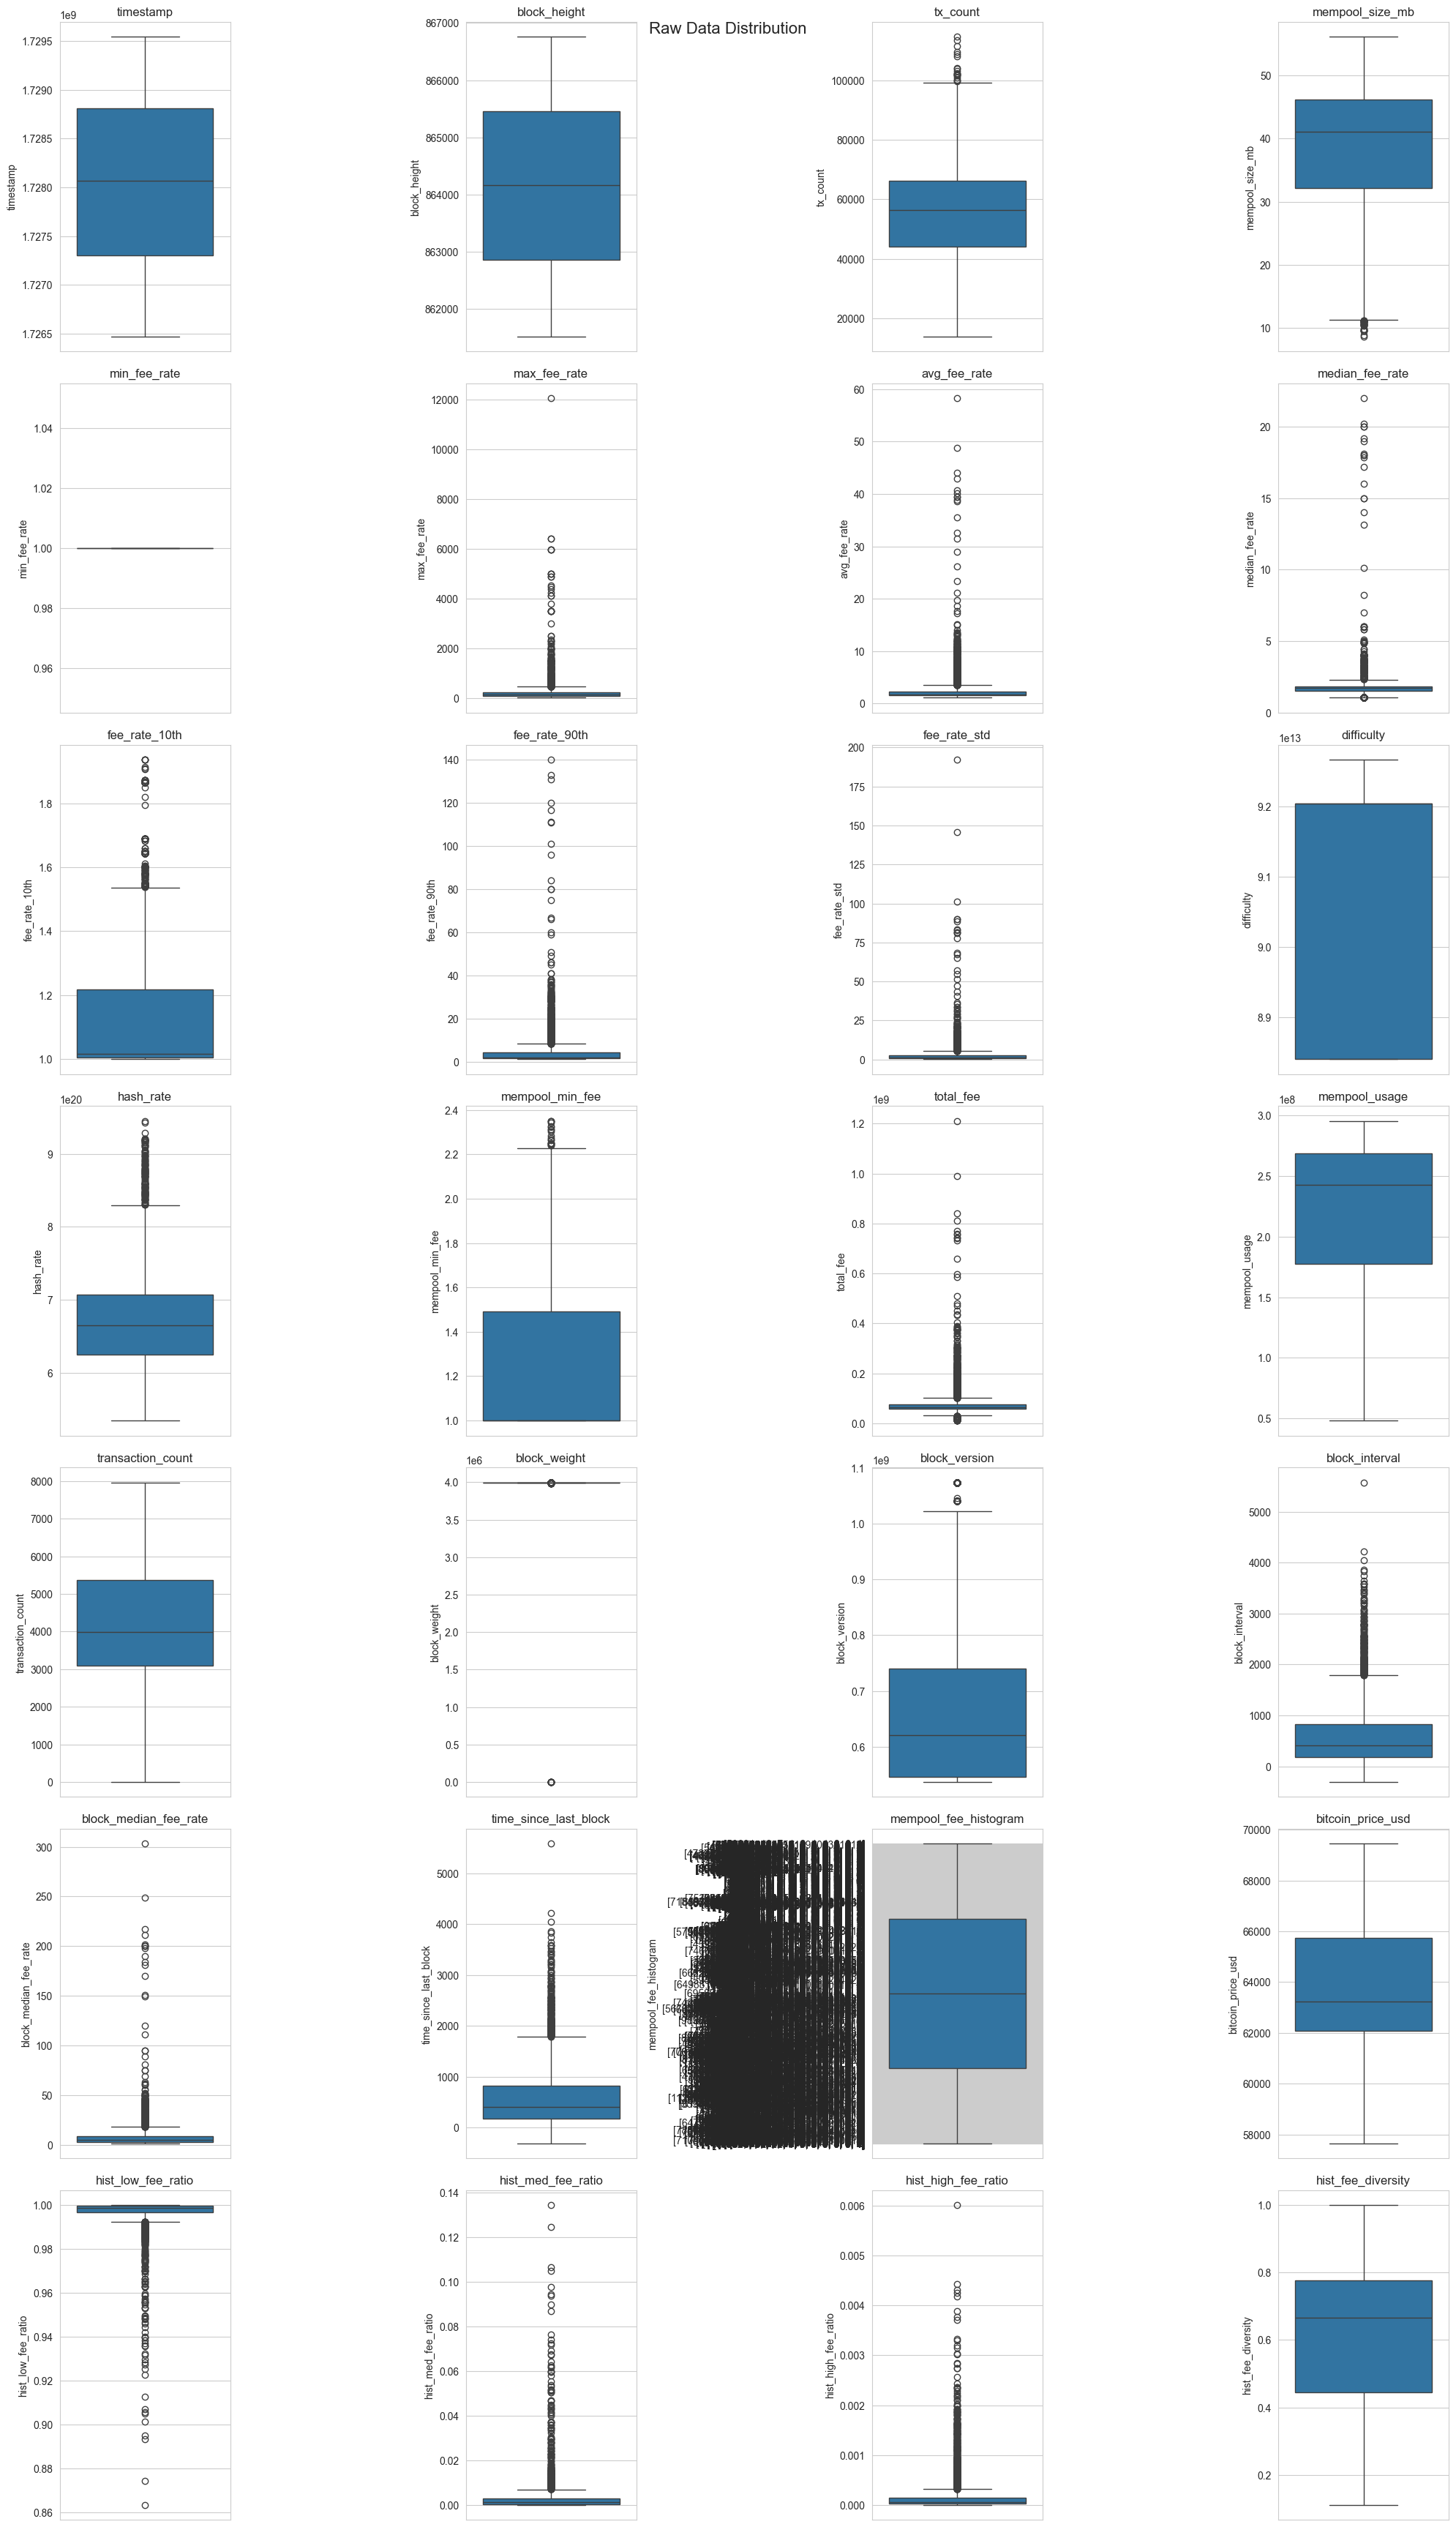

In [17]:
print("Original data_history shape:", df.shape)

duplicates = df.duplicated().sum()
df = df.drop_duplicates()
print(f"Removed {duplicates} duplicate rows.")

nan_counts = df.isna().sum()
columns_with_nan = nan_counts[nan_counts > 0]
if not columns_with_nan.empty:
    print("\nColumns with NaN values:")
    print(columns_with_nan)
    
    # Handle NaN values
    median_interval = df['block_interval'].median()  # Calculate median interval once
    for column in columns_with_nan.index:
        if column == 'block_interval':
            # For the first row, use the median interval. For others, forward fill.
            df['block_interval'] = df['block_interval'].ffill().fillna(median_interval)
        elif column == 'block_median_fee_rate':
            # Use forward fill, then backward fill for any remaining NaNs
            df[column] = df[column].ffill().bfill()
        elif column in ['mempool_size_mb', 'tx_count', 'mempool_usage']:
            # For mempool-related metrics, 0 might be appropriate if the mempool was empty
            df[column] = df[column].fillna(0)
        else:
            # For other columns, use forward fill, then backward fill
            df[column] = df[column].ffill().bfill()

    remaining_nans = df.isna().sum()[df.isna().sum() > 0]
    if not remaining_nans.empty:
        print("\nRemaining NaN values after handling:")
        print(remaining_nans)
    else:
        print("No NaN values found after handling.")
else:
    print("No NaN values found.")

# If there are still any NaN values, drop those rows
rows_before = df.shape[0]
df = df.dropna()
rows_after = df.shape[0]
if rows_before > rows_after:
    print(f"\nDropped {rows_before - rows_after} rows with remaining NaN values.")


if df.empty:
    print("Warning: DataFrame is empty after cleaning. Please check the data_history processing steps.")
else:
    # Plotting the distribution of the cleaned data_history
    plot_boxplots(df, "Raw Data Distribution")


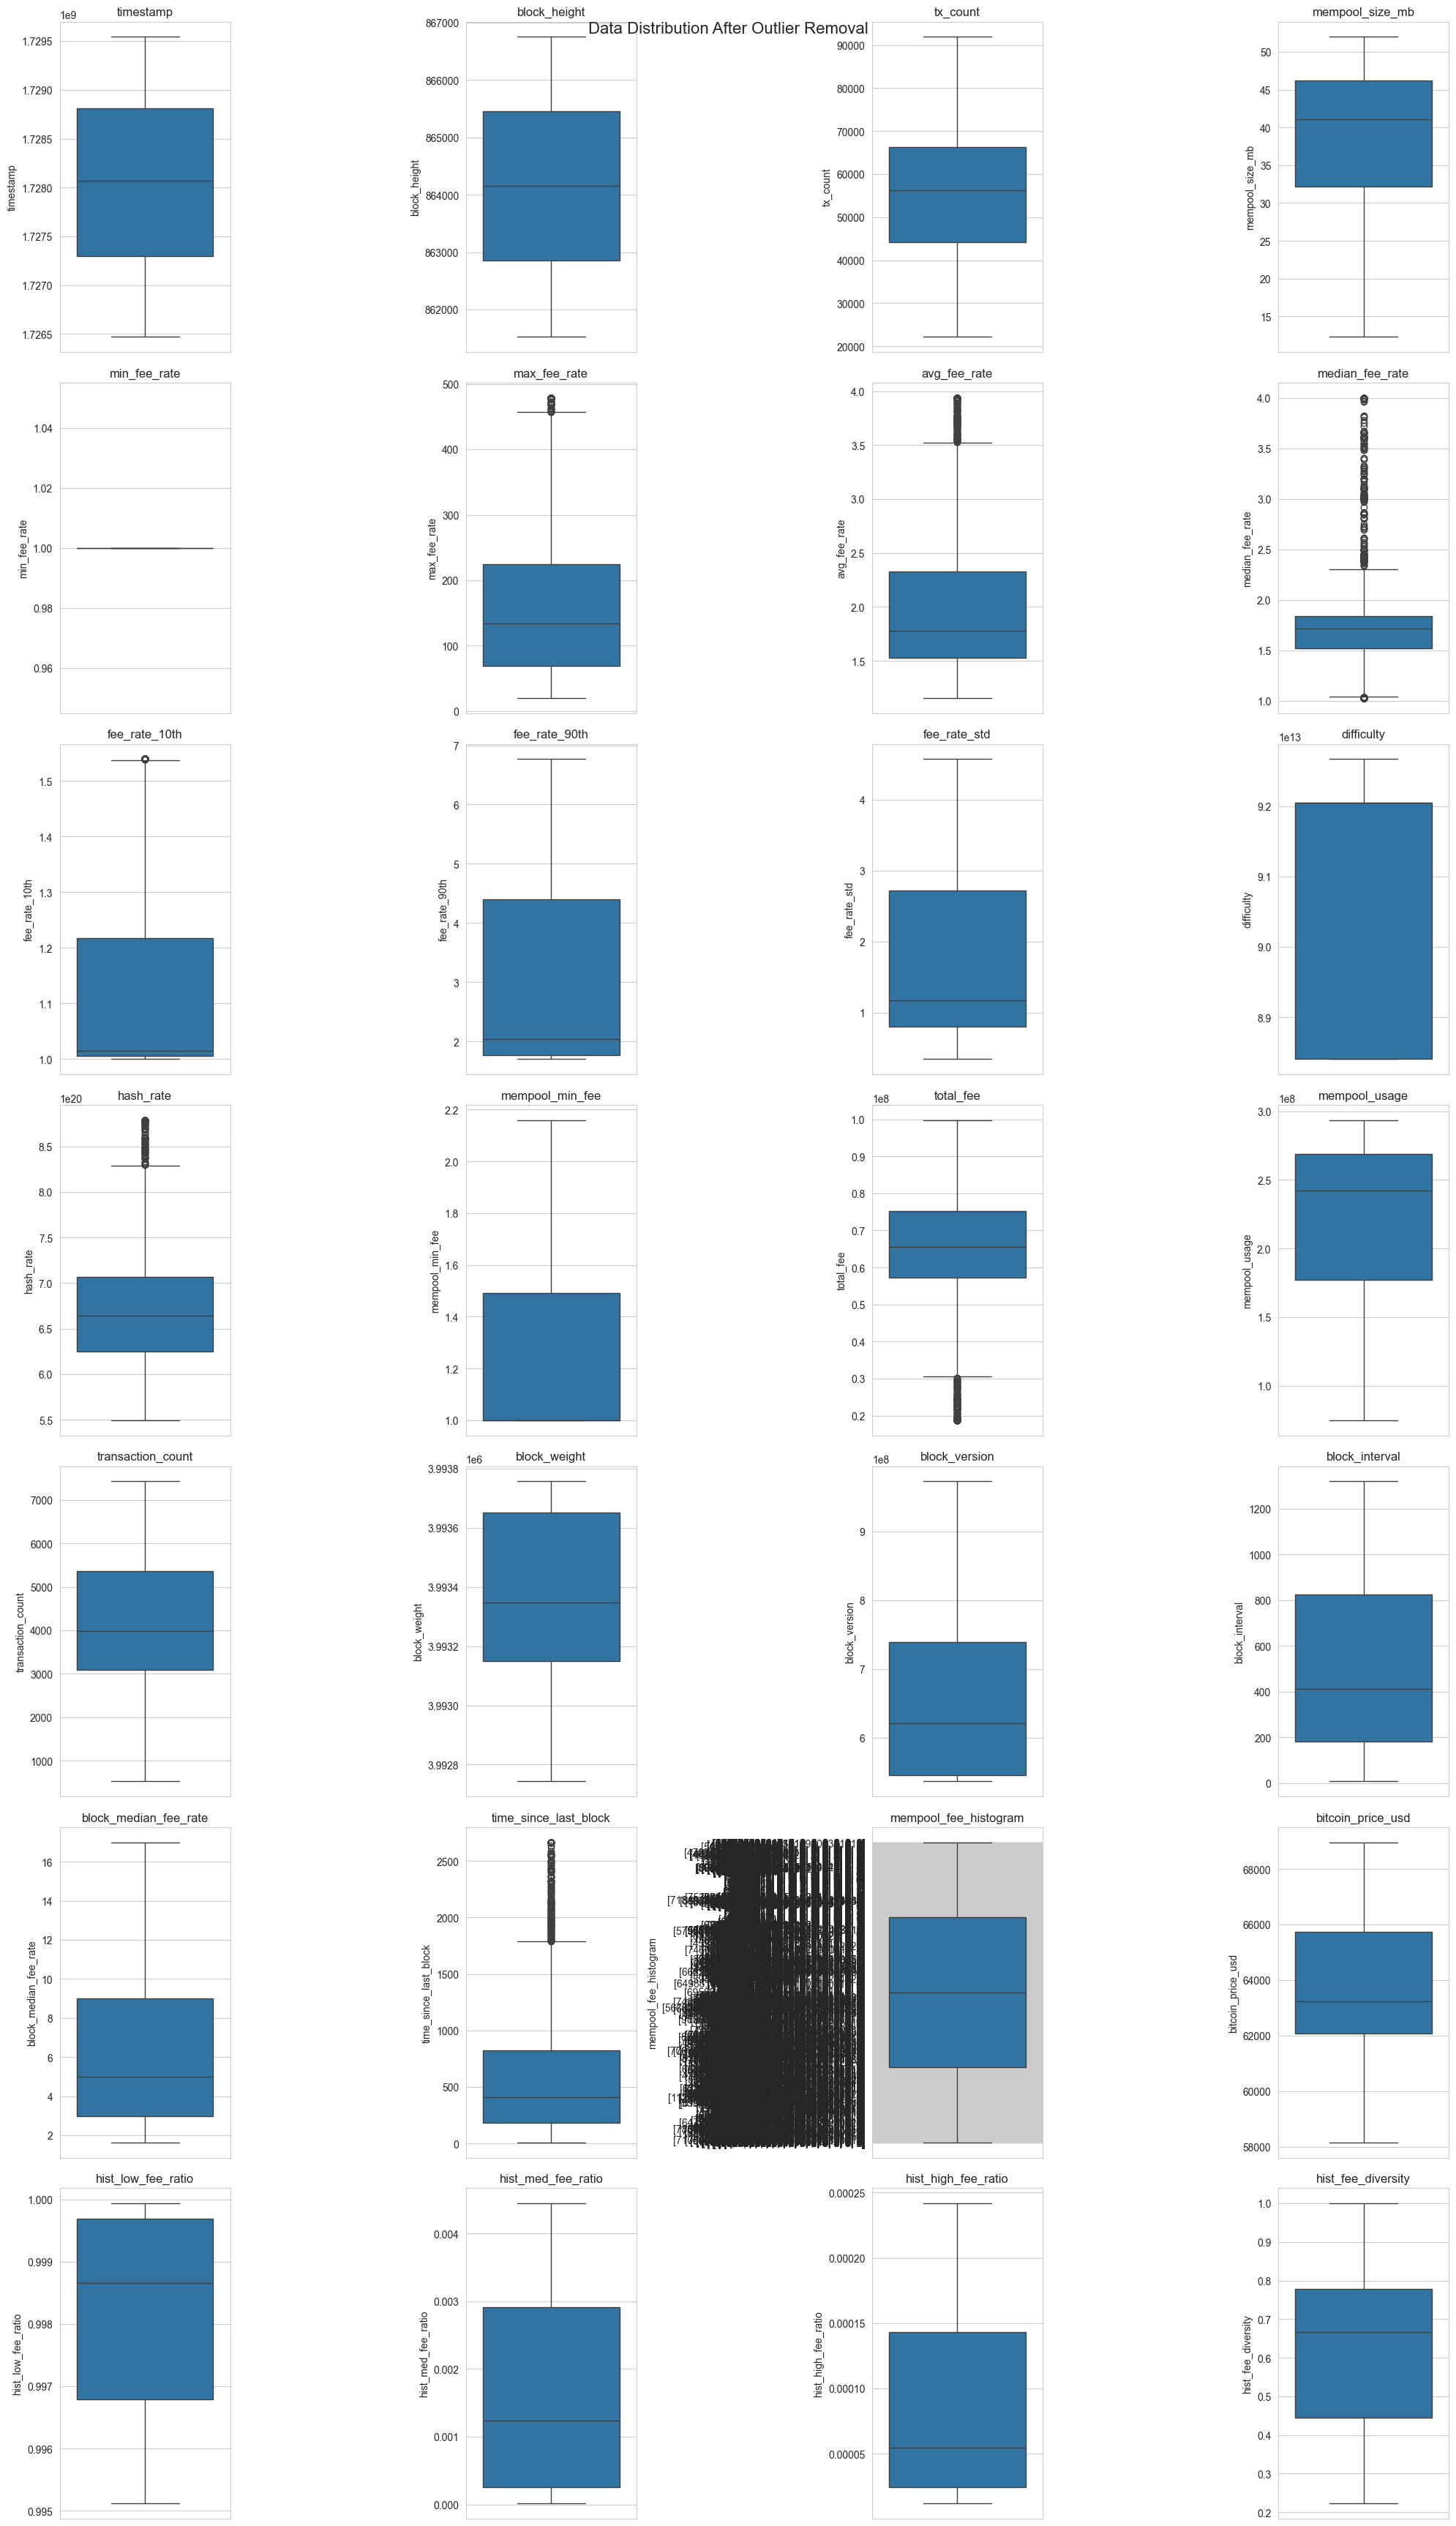

In [18]:
# Define a function to remove outliers by clipping based on percentiles
def handle_outliers(data, column, lower_percentile=1, upper_percentile=99):
    lower = np.percentile(data[column], lower_percentile)
    upper = np.percentile(data[column], upper_percentile)
    data[column] = data[column].clip(lower, upper)
    return data

# Define a dictionary for custom percentiles for each column
percentile_dict = {
    'fee_rate_90th': (5, 85),
    'fee_rate_10th': (1, 90),
    'difficulty': (20, 99),
    'max_fee_rate': (1, 90),
    'avg_fee_rate': (1, 90),
    'fee_rate_std': (1, 85),
    'total_fee': (1, 90),
    'block_weight': (1, 85),
    'block_interval': (1, 90),
    'block_median_fee_rate': (1, 90),
    'bitcoin_price_used': (1, 90),
   'block_version': (1, 95),
    'hist_low_fee_ratio': (15, 95),
    'hist_med_fee_ratio': (1, 85),
    'hist_high_fee_ratio': (1, 85)
}

# Apply outlier handling with custom percentiles
for column in df.columns:
    if column in percentile_dict:
        lower_p, upper_p = percentile_dict[column]
        df_cleaned = handle_outliers(df, column, lower_p, upper_p)
    elif column not in ['block_height', 'timestamp', 'mempool_fee_histogram']:
        df_cleaned = handle_outliers(df, column)



plot_boxplots(df_cleaned, "Data Distribution After Outlier Removal")

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_time_series(df, features, rows=3, cols=3, figsize=(20, 15)):
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten() 
    
    for i, feature in enumerate(features):
        if i < len(axes) and feature in df.columns:
            ax = axes[i]
            df.plot(y=feature, ax=ax)
            ax.set_title(feature)
            ax.set_xlabel('Time')
            ax.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()


block_features = ['block_height', 'timestamp', 'block_weight', 'block_version', 'block_interval', 'block_median_fee_rate', 'transaction_count']

mempool_features = ['tx_count', 'min_fee_rate', 'max_fee_rate', 'avg_fee_rate', 'median_fee_rate', 'fee_rate_10th', 'fee_rate_90th', 'fee_rate_std', 'mempool_min_fee', 'mempool_size_mb', 'mempool_usage', 'total_fee','hist_low_fee_ratio', 'hist_med_fee_ratio', 'hist_high_fee_ratio','hist_fee_diversity']

network_features = ['difficulty', 'hash_rate']

bitcoin_features = ['bitcoin_price_usd']



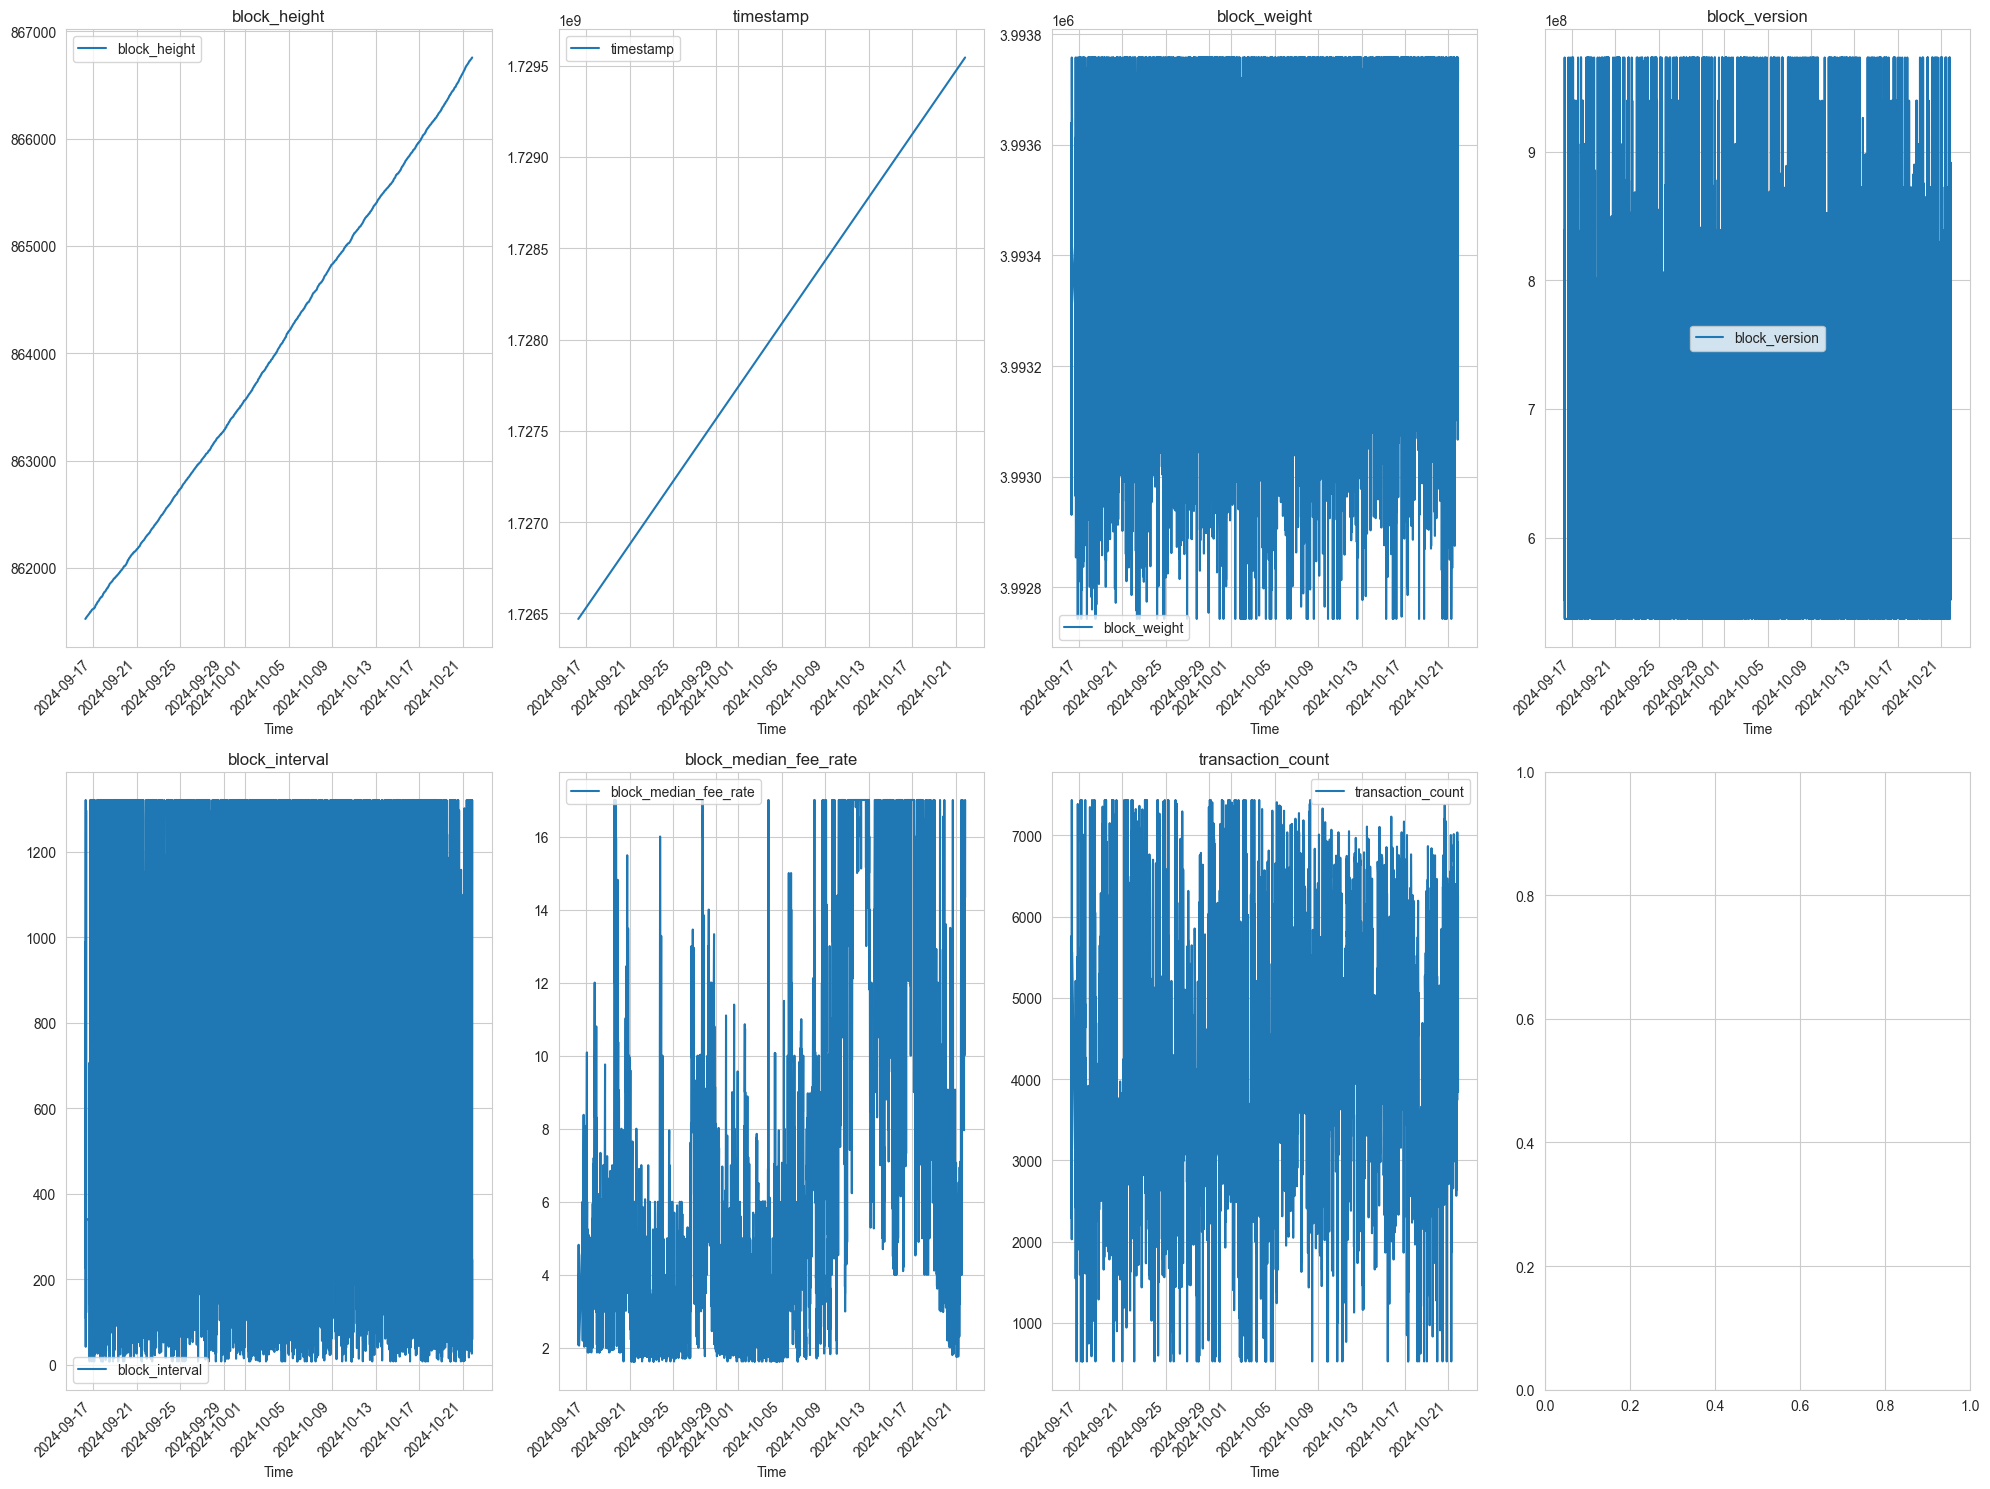

In [20]:
plot_time_series(df_cleaned, block_features,rows=2, cols=4)

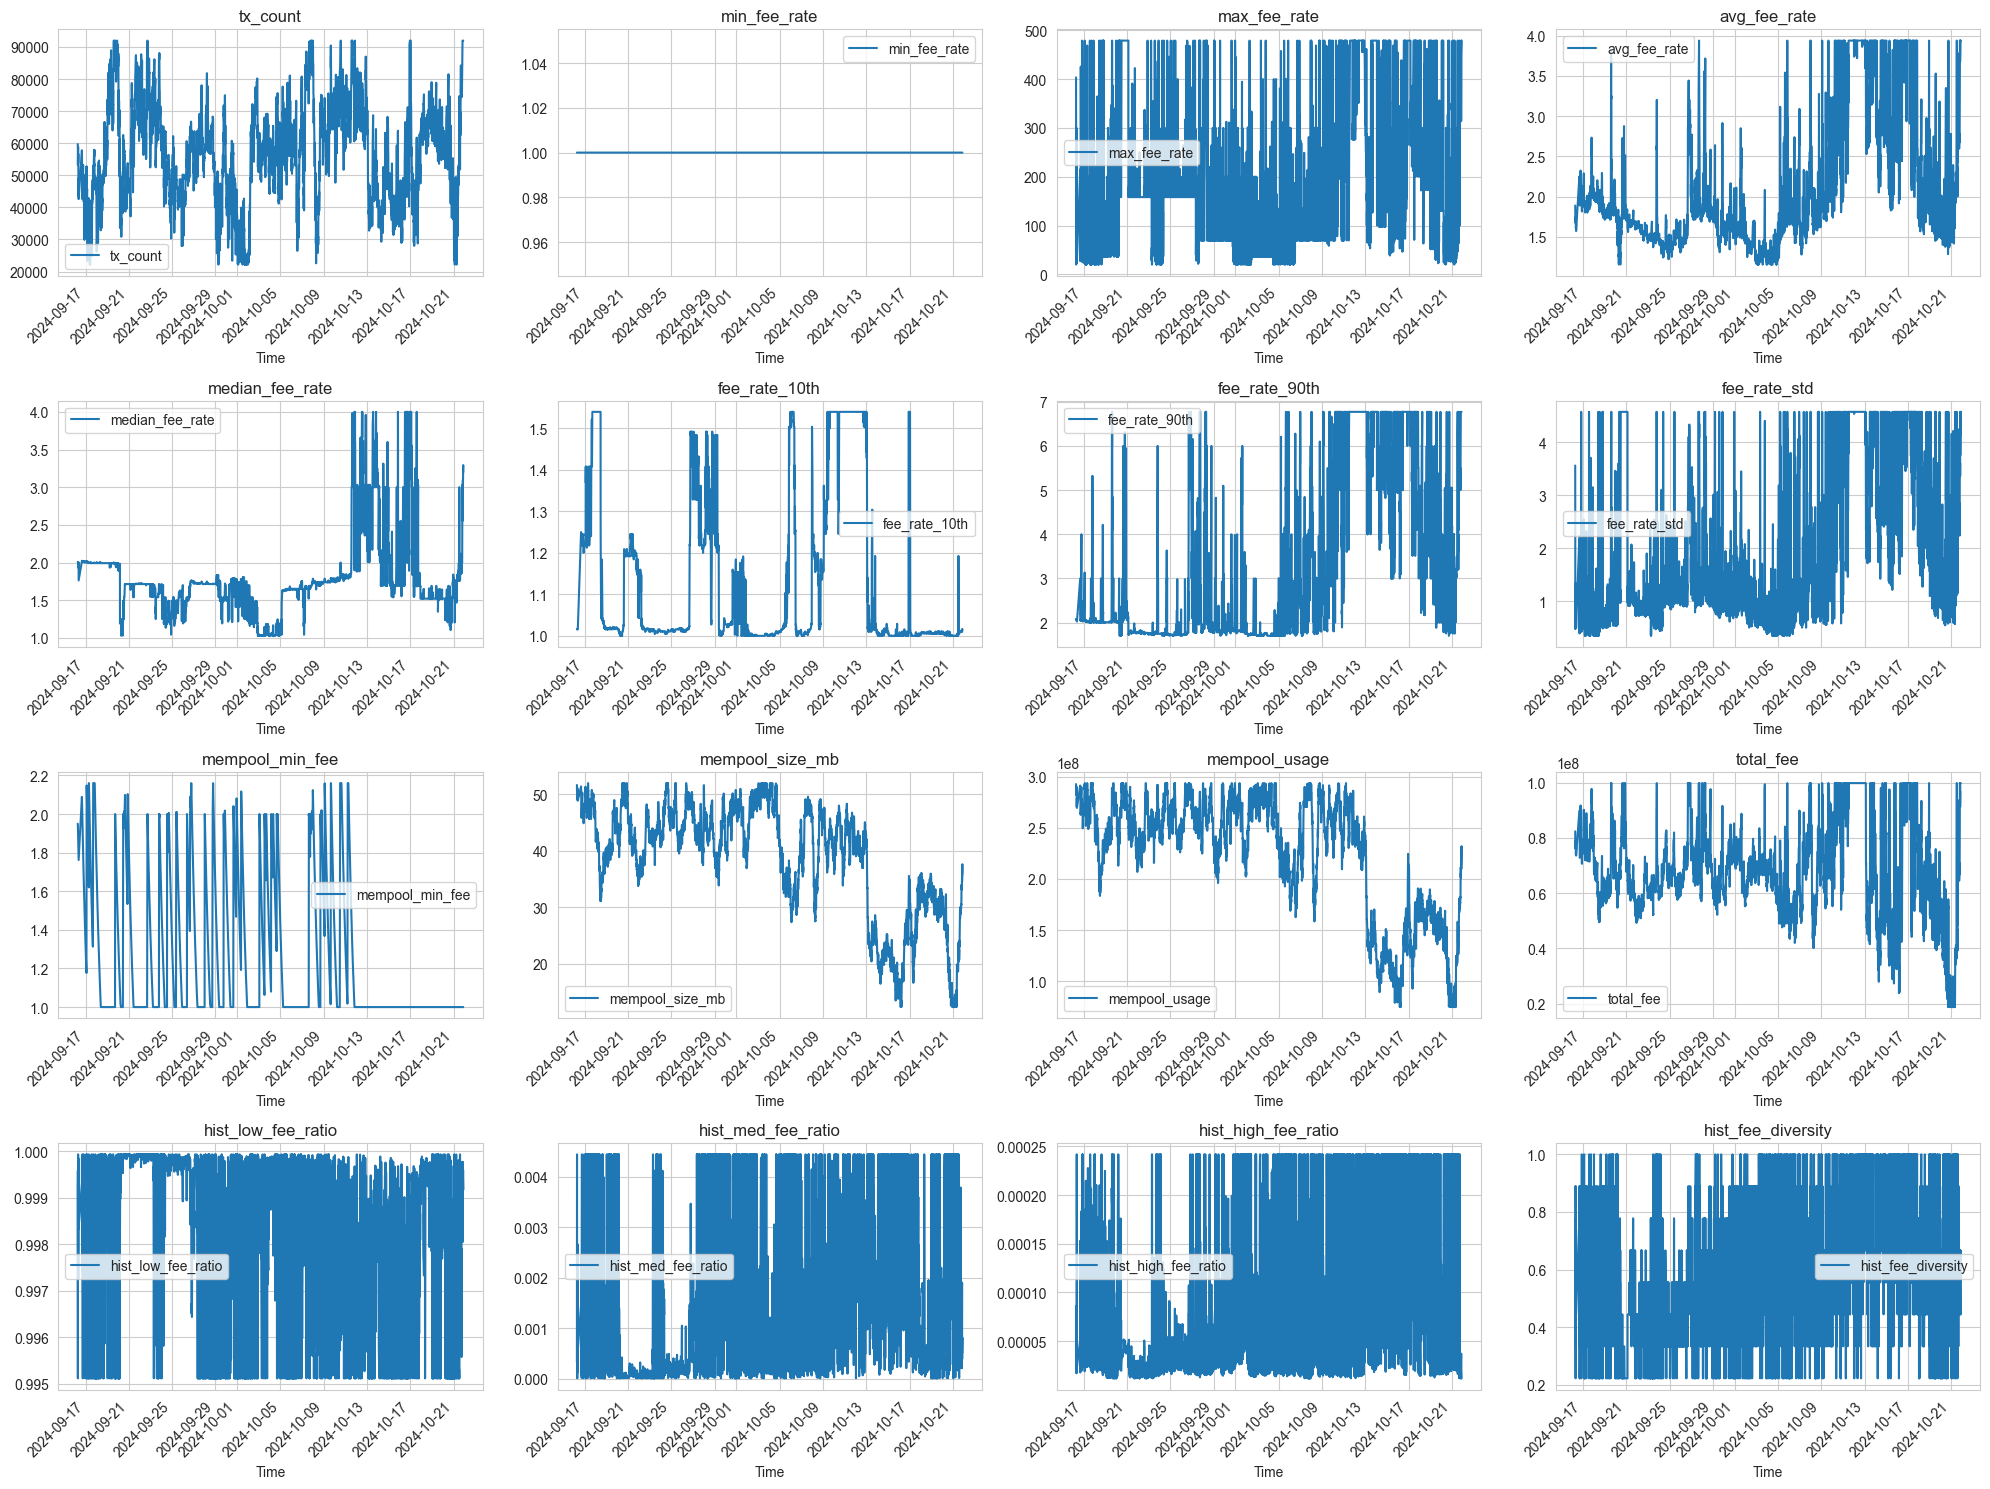

In [21]:
plot_time_series(df_cleaned, mempool_features,rows=4, cols=4)

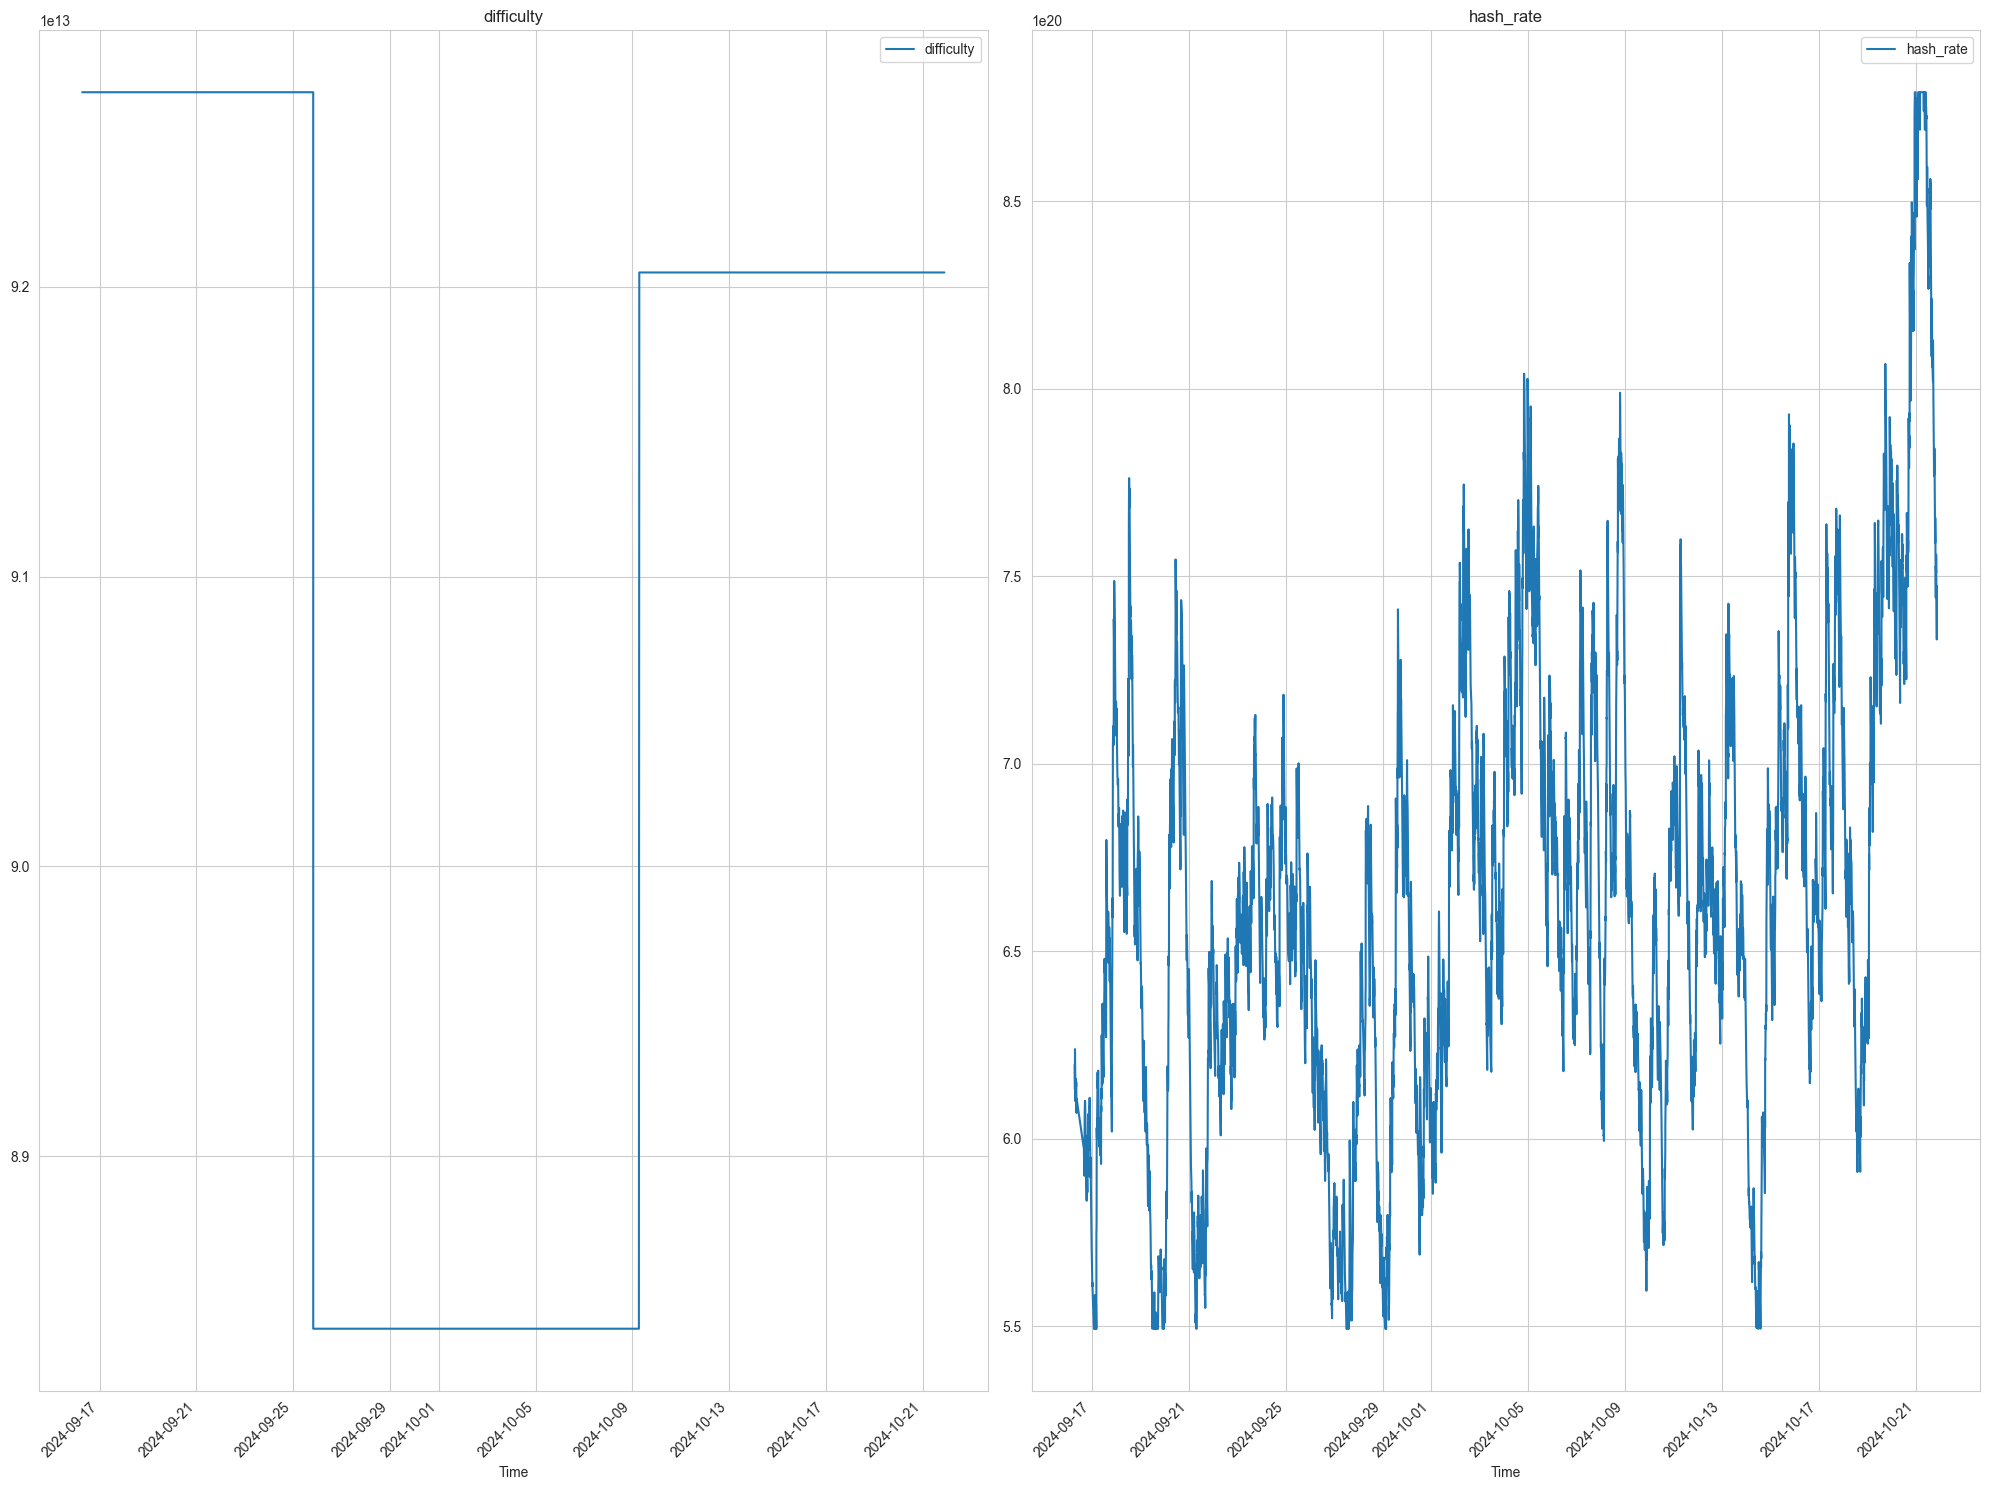

In [22]:
plot_time_series(df_cleaned, network_features,rows=1, cols=2)

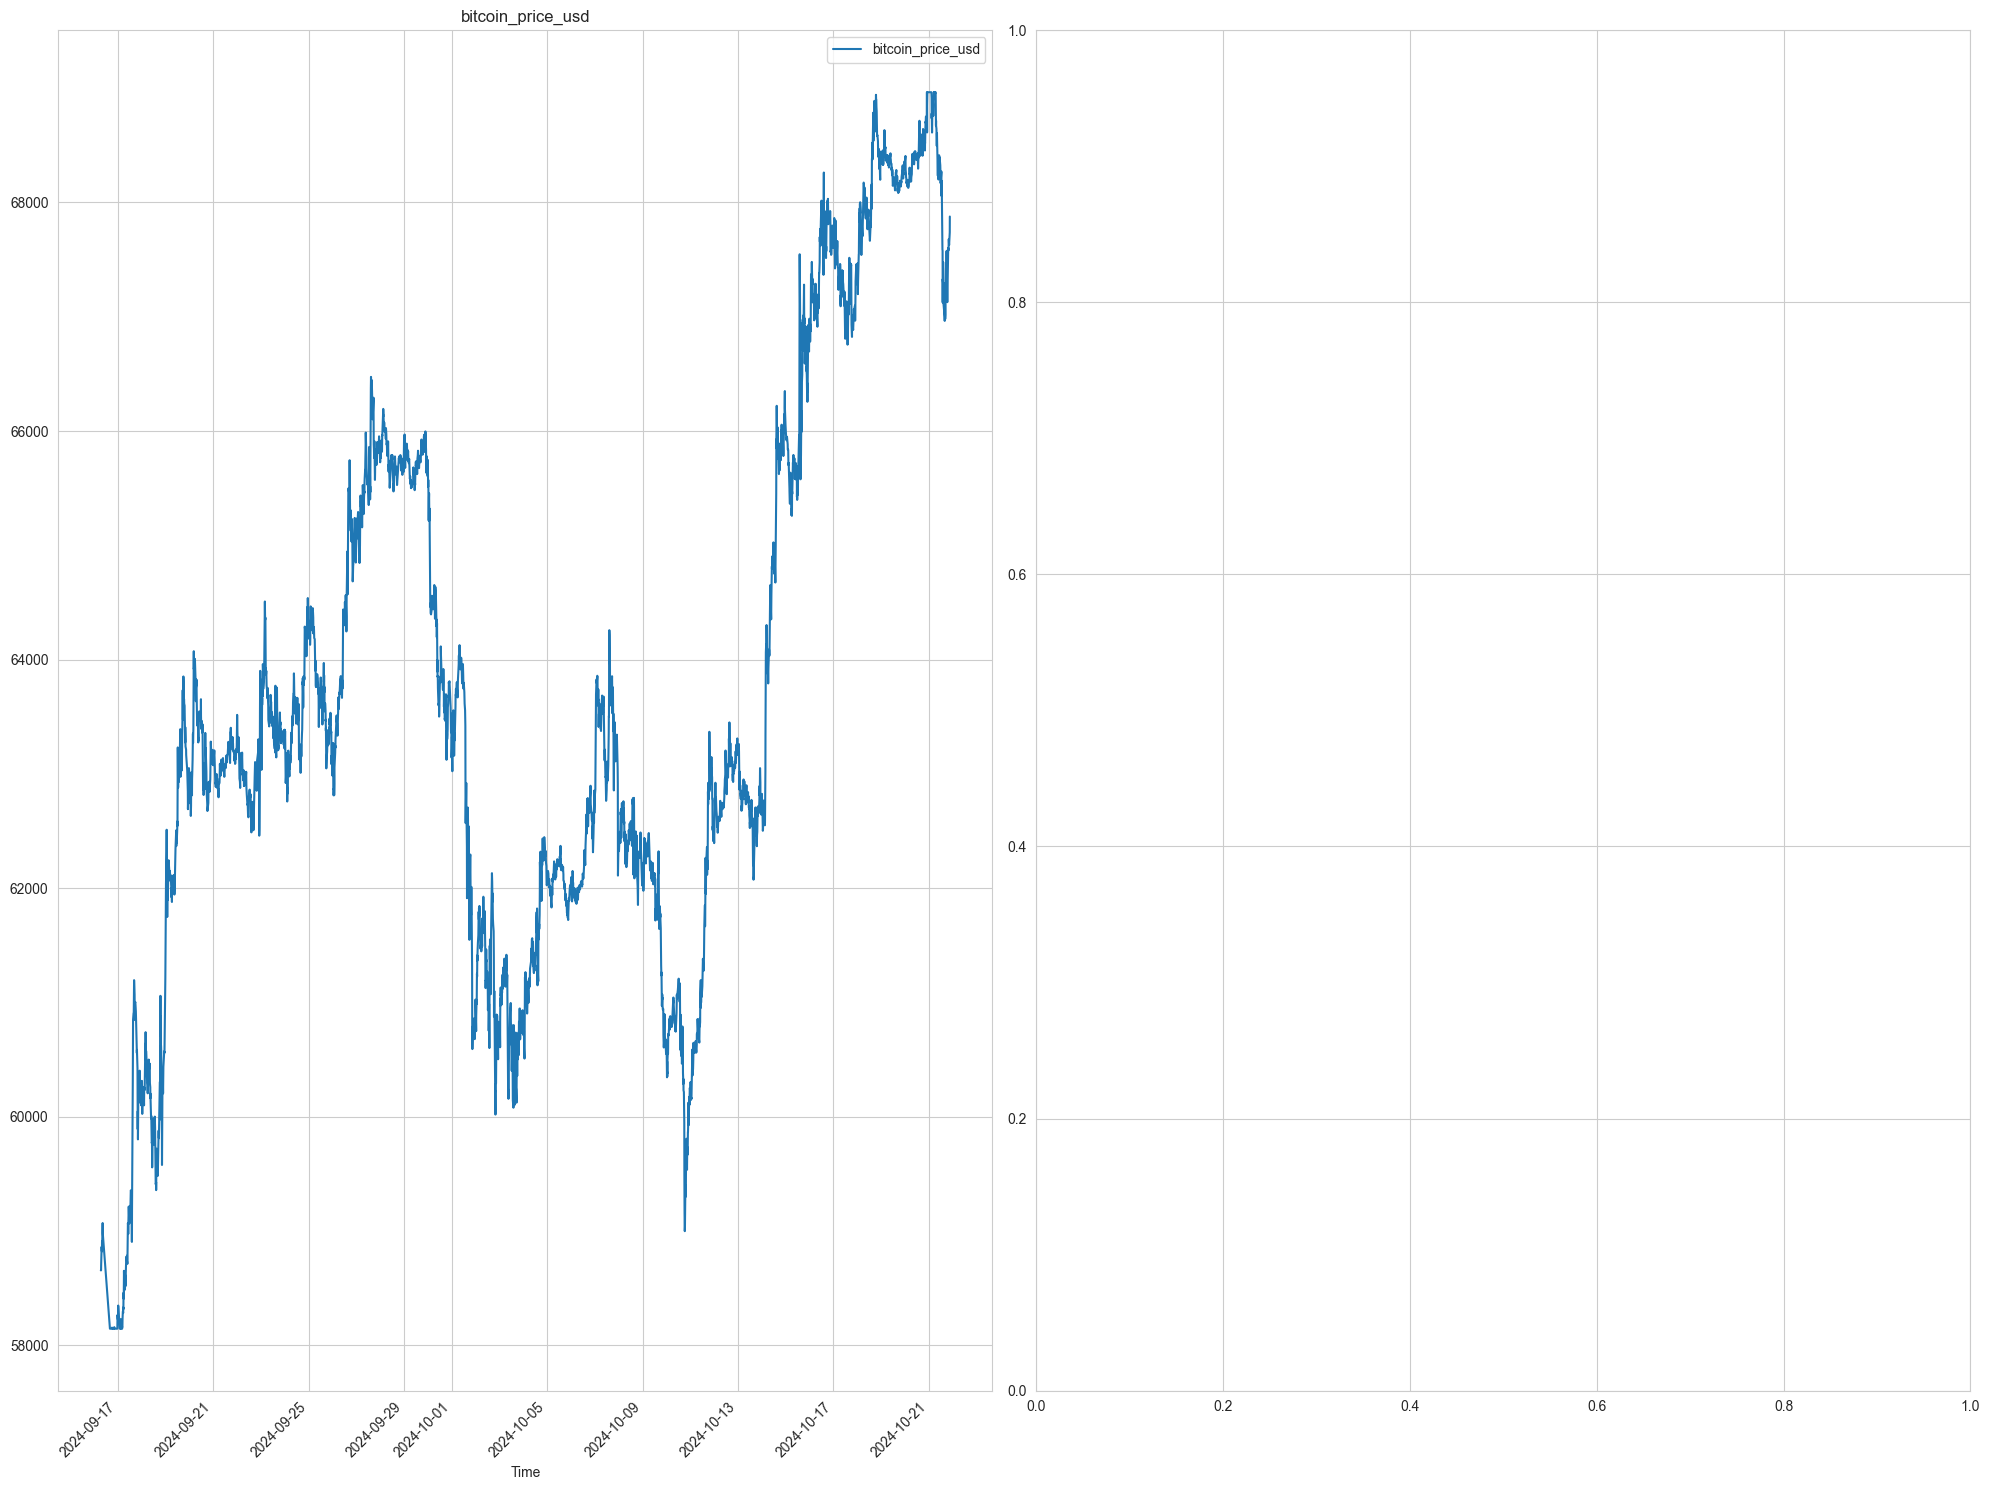

In [23]:
plot_time_series(df_cleaned, bitcoin_features,rows=1, cols=2)

In [24]:
df_cleaned.drop(columns=['time_since_last_block','timestamp','min_fee_rate'], inplace=True)

In [25]:
df_cleaned.to_csv('real_time_cleaned.csv')

In [26]:
pd.read_csv('real_time_cleaned.csv').shape

(5169, 26)

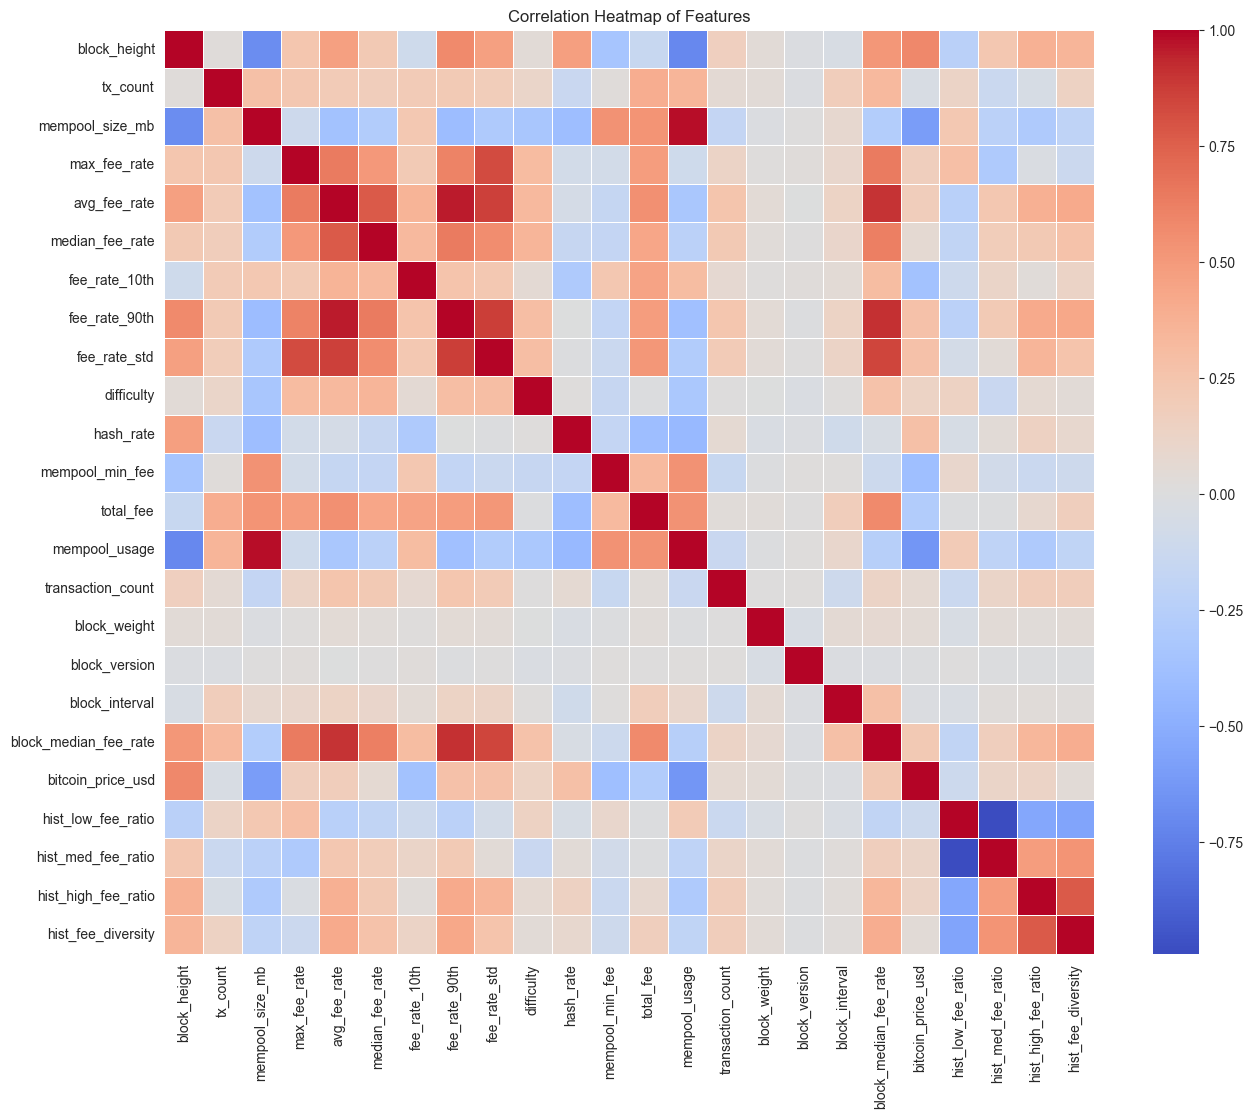

<Figure size 640x480 with 0 Axes>

In [27]:
# Correlation heatmap
plt.figure(figsize=(15, 12))
sns.heatmap(df_cleaned.drop(columns=['mempool_fee_histogram']).corr(), annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Features')
plt.show()
plt.savefig('correlation_heatmap.png')